# Исследование объявлений о продаже квартир

Для исследования взяты данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Часть данных запоняется пользователем, часть - определена автоматически, как, например, расстояния до инфраструктурных объектов. Цель работы - выполнить предобработку данных, проанализировать влияние различных параметров недж=вижимости на цену.

## Импорт библиотек и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv('real_estate_data.csv', sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [3]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

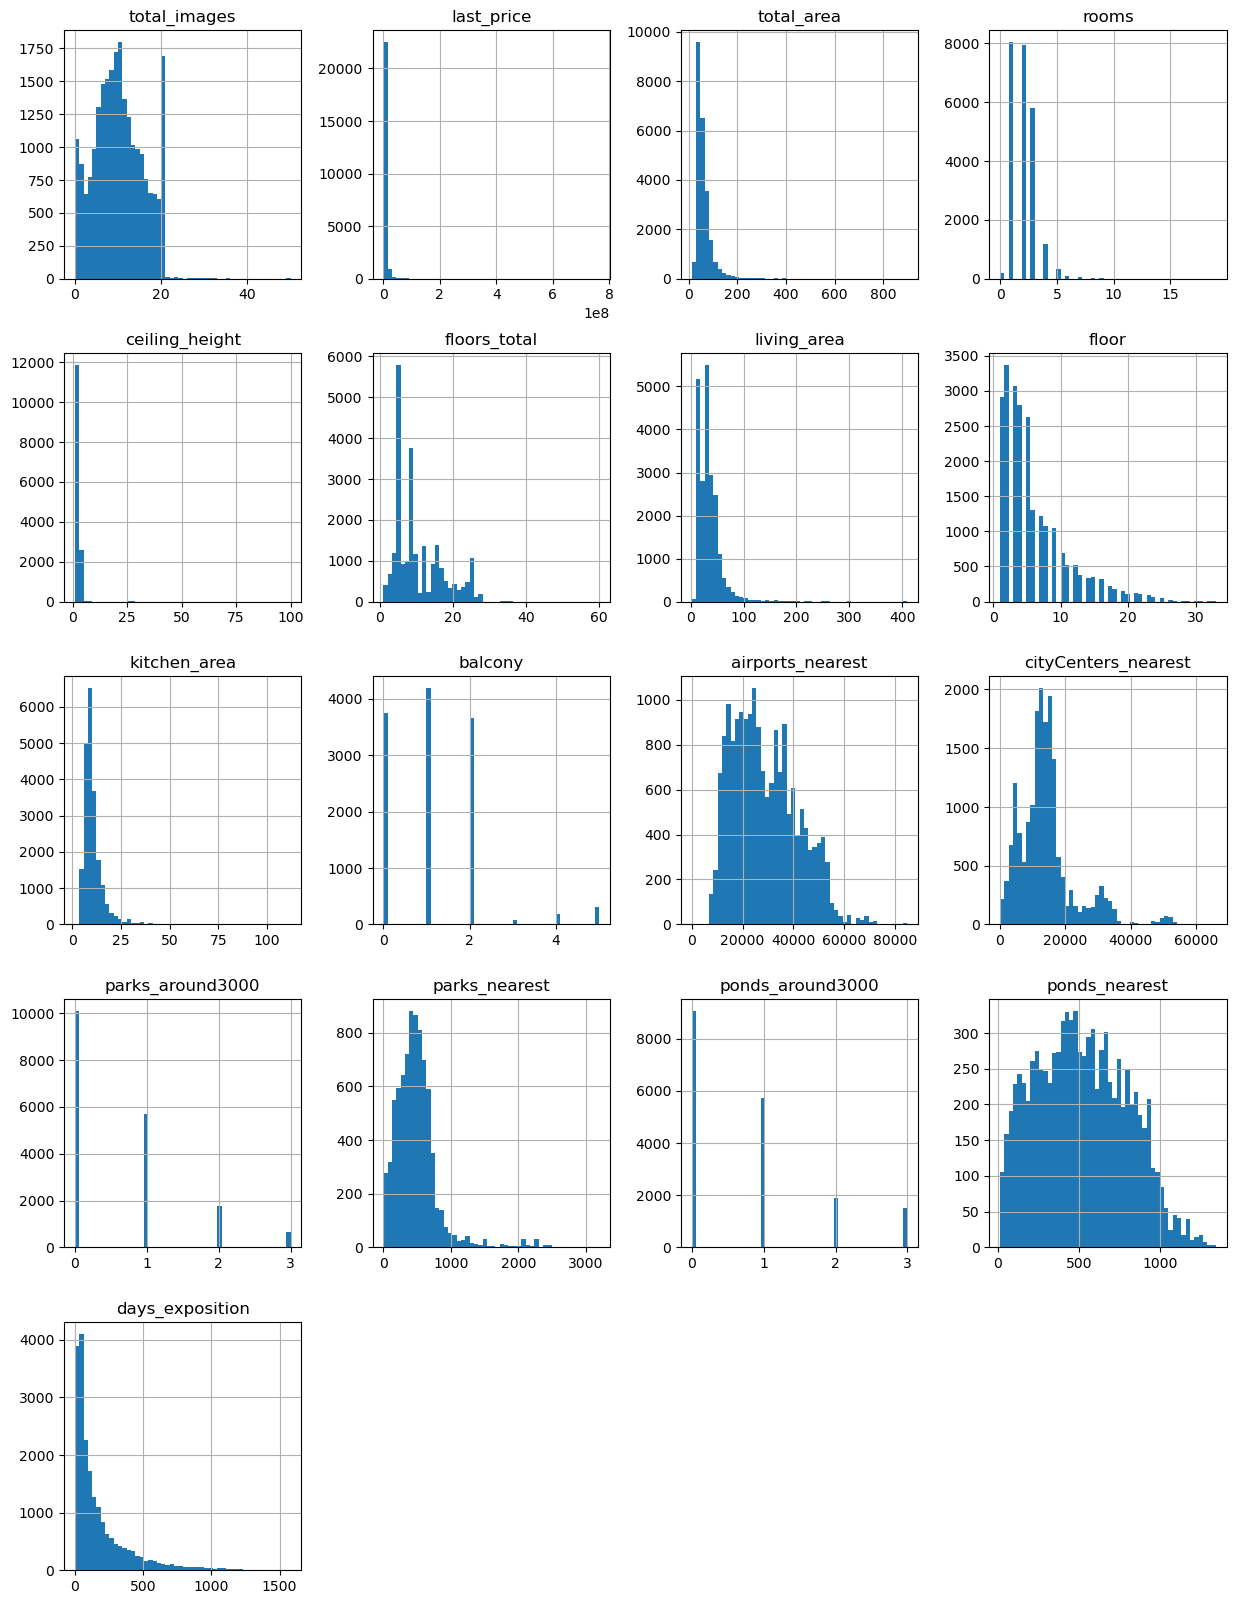

In [5]:
df.hist(figsize=(15,20), bins=50);

**Вывод по первичному осмотру данных**

- в 14 из 22 столбцов есть пропуски.
- тип данных в некоторых столбцах вызывает вопросы: явно целочисленные переменные имеют тип float
- по гистограммам цены, площади и количества комнат видны аномальные значения (длинные "хвосты" вправо)

### Пропуски

**Сперва разберемся с пропусками**
Начну с тех столбцов, где все очевидно:

- ceiling_height - высота потолка - Скорее всего, отсутствие этой информации - не более, чем дефект в исходных данных, имеет случайную природу, поэтому логичнее всего заполнить медианным значением. 
- living_area - пропуск в жилой площади заполню медианным значением для недвижимости с тем же количеством комнат
- is_apartment - пропуски более чем в 80% записей. Там, где пропуска нет - лежит значение "False". Поскольку, во-первых, такой тип недвижимости, как апартаменты не очень широко распространен, к тому же в описании датасета речь идет о квартирах, которыми, строго говоря, апартаменты не являются. Поэтому все пропуски также заполню значением "False" и буду считать эту информацию в данном случае к делу не относящейся
- balcony - количество балконов. Пропуск воспринимаю как отсутствие балкона, заполняю значением "0"
- locality_name - локацию придумать или восстановить не получится, эти значения останутся пустыми
- parks_around3000 - количество парков. Пропуск интерпретирую как отсутствие парка, заполняю значением "0"
- ponds_around3000 - количество прудов. Пропуск интерпретирую как отсутствие пруда, заполняю значением "0"

*Вот с этими столбцами изначально я хотел поступить вот так*
- ponds_nearest- заполню медианным значением для данной локации, если пруды поблизости есть. Если нет - оставлю пустым
- parks_nearest - заполню медианным значением для данной локации, если парки поблизости есть. Если нет - оставлю пустым
- cityCenters_nearest - скорее всего, также случайный пропуск, заполню медианным значением для данной локации
- airports_nearest - заполню медианным значением для данной локации

Однако, оказалось, что практически везде в пределах локации расстояние не указано нигде, то есть, медиана также принимает знаяение NaN (см. ниже). От этой идеи отказался, и оставил пропуски. Очень жаль :(


In [6]:
df_grouped = df.groupby('locality_name').agg({'ponds_nearest':['median'], 'parks_nearest':['median'], \
                                             'cityCenters_nearest':['median'], 'airports_nearest':['median']})
df_grouped

,ponds_nearest,parks_nearest,cityCenters_nearest,airports_nearest
,median,median,median,median
locality_name,,,,
Бокситогорск,NaN,NaN,NaN,NaN
Волосово,NaN,NaN,NaN,NaN
Волхов,NaN,NaN,NaN,NaN
Всеволожск,NaN,NaN,NaN,NaN
Выборг,NaN,NaN,NaN,NaN
...,...,...,...,...
село Путилово,NaN,NaN,NaN,NaN
село Рождествено,NaN,NaN,NaN,NaN


Также интерес вызывает недвижимость с неуказанной локацией, стоит посмотреть, нет ли там каких-то аномалий по цене

<AxesSubplot: >

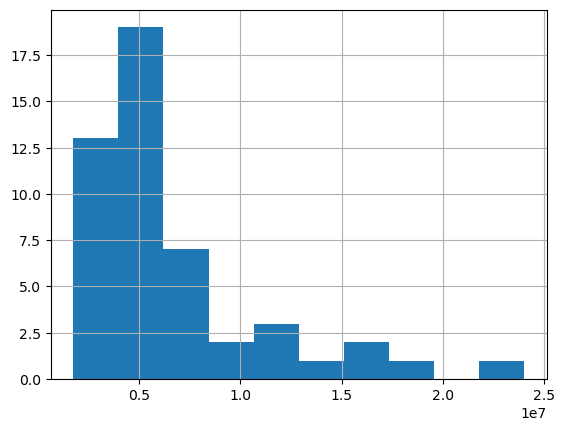

In [7]:
df[df['locality_name'].isna()]['last_price'].hist(bins=10)

При некоторой фантазии выше можно увидеть распределение Пуассона, что может говорить о том, что локации не указаны случайно.
Таких записей всего 49, поэтому их можно удалить

In [8]:
df = df.dropna(subset=['locality_name'])

In [9]:
#высота потолков
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())

#апартаменты
df['is_apartment'] = df['is_apartment'].fillna(False)

#балконы, парки и пруды
df['balcony'] = df['balcony'].fillna(0)
df['parks_around3000'] = df['parks_around3000'].fillna(0)
df['ponds_around3000'] = df['ponds_around3000'].fillna(0)

#жилая площадь
for n in df['rooms'].unique():
    df.loc[(df['rooms'] == n) & (df['living_area'].isna()), 'living_area'] = \
    df.loc[(df['rooms'] == n), 'living_area'].median()

Теперь столбцы, где не все так однозначно. 
- floors_total
- kitchen_area 
- days_exposition

Пропуск в количестве этажей может означать, что дом одноэтажный. Посмотрим, так ли это.

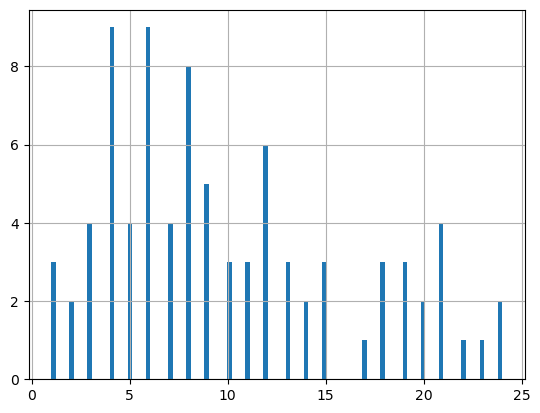

In [10]:
df[df['floors_total'].isna()]['floor'].hist(bins=100);

Увы. Гипотеза Одноэтажной Ленобласти не подтвердилась. 
Заполню тогда пропуски в числе этажей максимальным значением этажа для данной локации. 
От дополнительных 86 25-этажек в Мурино и Кудрово хуже уже не станет...  

In [11]:
for l in df['locality_name'].unique():
    df.loc[(df['locality_name'] == l) & (df['floors_total'].isna()), 'floors_total'] = \
    df.loc[(df['locality_name'] == l), 'floors_total'].max()

Пропуск в площади кухни может означать, что это квартира-студия, где кухни как таковой и нету

In [12]:
df.loc[(df['kitchen_area'].isna()) & (df['studio'])]['kitchen_area'].count()

0

Странно. А что, если так?

In [13]:
df.loc[df['rooms'] == 0]['studio']

144       True
349      False
440       True
508      False
608       True
         ...  
23210     True
23442    False
23554     True
23592    False
23637     True
Name: studio, Length: 197, dtype: bool

Очень странно. Не все квартиры с 0 комнат являются студиями. Придется поправить.

И для квартир-студий площадь кухни сделать равной 0, а для всех остальных - сделать медианой для данного количества комнат

In [14]:
df.loc[(df['rooms'] == 0), 'studio'] = True


df.loc[(df['studio'] == True), 'kitchen_area'] = 0

for n in df['rooms'].unique():
    df.loc[(df['studio'] == False) & (df['rooms'] == n) & (df['kitchen_area'].isna()), 'kitchen_area'] = \
    df.loc[(df['studio'] == False) & (df['rooms'] == n), 'kitchen_area'].median()

**И посмотрим что получилось**
После всех этих манипуляций пропуски должны остаться в столбцах:
- ponds_nearest
- parks_nearest
- cityCenters_nearest
- airports_nearest
- days_exposition

In [15]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5534
cityCenters_nearest      5511
parks_around3000            0
parks_nearest           15586
ponds_around3000            0
ponds_nearest           14565
days_exposition          3180
dtype: int64

### Типы данных

- В столбце "first_day_exposition" явно должен быть тип данных "date_time", с округлением до дня 
- "parks_around3000" и "ponds_around3000" - должны быть целочисленными значениями.

In [16]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition']).dt.round('1D')
df.astype({"parks_around3000": "int", "ponds_around3000": "int", "floors_total": "int"})

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.00,0.0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
1,7,3350000.0,40.40,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0
3,0,64900000.0,159.00,2015-07-24,3,2.65,14,45.0,9,False,False,False,9.50,0.0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.00,0.0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5,73.3,3,False,False,False,13.83,0.0,Санкт-Петербург,24665.0,4232.0,1,796.0,3,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15,3,2.65,5,38.0,4,False,False,False,8.50,0.0,Тосно,NaN,NaN,0,NaN,0,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11,2,2.65,3,29.7,1,False,False,False,8.80,0.0,село Рождествено,NaN,NaN,0,NaN,0,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17,30.5,12,False,False,False,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2,173.0,3,196.0,602.0


### Дубликаты

Явные дубликаты

In [17]:
df.duplicated().sum()

0

Удаление дубликатов с ё/е в названиях

In [18]:
def yo_changer(str):
    return(str.replace('ё','е'))

df['locality_name'] = df['locality_name'].apply(yo_changer)

От посЁлков избавились, теперь посмотрим на имена собственные в названиях. 
Видно, что имя собственное всегда идет последним (Кроме многочисленных Красных, Сосновых и Трубниковых Боров), 
а слова в названии разделены пробелами

In [19]:
name_list = []
locality_list = []
count = 0

for st in df['locality_name'].unique():
    n = st.lower().split()
    if n[-1] in name_list and n[-1] != 'бор':
        count += 1
        locality_list.append(st)
    name_list.append(n[-1])
    
#print(count)
#locality_list

Сравнение полученного списка с df['locality_name'].unique() показывает, что неявные дубликаты встречаются только в 
поселках городского типа и поселках при станциях. Так, например, Кудрово и деревня Кудрово - это разные населенные пункты,
а вот ПГТ и городской поселок - это одно и то же

In [20]:
name_list = []
locality_list = []

for st in df['locality_name'].unique():
    n = st.lower().split()
    if n[-1] in name_list and n[-1] != 'бор'\
    and ('поселок город' in st or 'станции' in st or 'городcкой поселок' in st):
        locality_list.append(st)
    name_list.append(n[-1])
    
locality_list

['поселок городского типа Рябово',
 'поселок городского типа Мга',
 'поселок городского типа Павлово',
 'поселок городского типа Лесогорский',
 'поселок при железнодорожной станции Вещево',
 'поселок городского типа Назия',
 'поселок при железнодорожной станции Приветнинское',
 'поселок городского типа Большая Ижора']

Время избавиться от лишних сущностей на карте

In [21]:
l1 = ['городской поселок Рябово', 'городской поселок Мга', 'городской поселок Павлово', 'городской поселок Лесогорский', \
     'поселок станции Вещево', 'городской поселок Назия', 'поселок станции Приветнинское', 'городской поселок Большая Ижора']
l2 = ['поселок городского типа Рябово', 'поселок городского типа Мга', 'поселок городского типа Павлово',\
     'поселок городского типа Лесогорский', 'поселок при железнодорожной станции Вещево', 'поселок городского типа Назия', \
     'поселок при железнодорожной станции Приветнинское', 'поселок городского типа Большая Ижора']
for i in range(0, len(l1)):
    df = df.replace(l1[i], l2[i])
df['locality_name'].nunique()

323

### Аномалии и выбросы

Аномалии ожидаются в следующих столбцах

In [22]:
col_name_list = ['total_images', 'last_price', 'total_area', 'rooms', 'ceiling_height', 'floors_total',\
'living_area', 'floor', 'kitchen_area', 'balcony', 'airports_nearest', 'cityCenters_nearest',\
'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition']

for st in col_name_list:
    print(st)
    print(df.sort_values(by=st, ascending=False)[st].head(10))
df.sort_values(by='last_price', ascending=False).head(10)
df.sort_values(by='rooms', ascending=False).head(10)

total_images
12667    50
17396    50
9778     50
15157    42
1058     39
21199    37
308      35
10523    35
99       32
7393     32
Name: total_images, dtype: int64
last_price
12971    763000000.0
19540    420000000.0
14706    401300000.0
1436     330000000.0
15651    300000000.0
22831    289238400.0
16461    245000000.0
13749    240000000.0
5893     230000000.0
8900     190870000.0
Name: last_price, dtype: float64
total_area
19540    900.0
12859    631.2
3117     631.0
15651    618.0
5358     590.0
4237     517.0
8018     507.0
15016    500.0
5893     500.0
12401    495.0
Name: total_area, dtype: float64
rooms
14498    19
18848    16
5358     15
866      14
20829    14
19540    12
9688     11
648      11
18891    10
4149     10
Name: rooms, dtype: int64
ceiling_height
22869    100.0
3148      32.0
22336     32.0
21377     27.5
17857     27.0
5246      27.0
20478     27.0
21824     27.0
10773     27.0
4876      27.0
Name: ceiling_height, dtype: float64
floors_total
2253     60.0
19133

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
14498,6,32250000.0,374.6,2018-06-09,19,2.65,5.0,264.5,2,False,False,False,27.6,0.0,Санкт-Петербург,19497.0,3574.0,0.0,NaN,2.0,548.0,114.0
18848,6,28500000.0,270.0,2015-03-02,16,3.00,4.0,180.0,4,False,False,False,13.0,1.0,Санкт-Петербург,23575.0,4142.0,1.0,516.0,0.0,NaN,1365.0
5358,20,65000000.0,590.0,2019-02-14,15,3.50,6.0,409.0,3,False,False,False,100.0,0.0,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0
866,5,25000000.0,363.0,2017-12-23,14,3.16,5.0,222.0,4,False,False,False,16.6,0.0,Санкт-Петербург,38076.0,7950.0,0.0,NaN,2.0,435.0,418.0
20829,6,28659000.0,245.4,2016-03-31,14,2.65,4.0,168.3,2,False,False,False,25.9,0.0,Санкт-Петербург,21104.0,2054.0,3.0,541.0,2.0,118.0,95.0
19540,8,420000000.0,900.0,2017-12-06,12,2.80,25.0,409.7,25,False,False,False,112.0,0.0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0
9688,8,33000000.0,194.1,2017-02-07,11,3.43,5.0,129.0,2,False,False,False,11.9,0.0,Санкт-Петербург,21469.0,1015.0,1.0,686.0,2.0,66.0,813.0
648,3,17500000.0,183.7,2018-07-01,11,3.40,7.0,138.8,7,False,False,False,13.3,0.0,Санкт-Петербург,23606.0,3148.0,0.0,NaN,0.0,NaN,NaN
18891,11,40000000.0,290.0,2016-06-21,10,3.50,6.0,189.4,6,False,False,False,30.0,1.0,Санкт-Петербург,26229.0,4932.0,3.0,316.0,1.0,227.0,77.0
4149,6,23000000.0,272.6,2018-01-11,10,3.14,7.0,145.9,7,False,False,False,18.8,1.0,Санкт-Петербург,10726.0,12169.0,1.0,191.0,1.0,531.0,NaN


Пожалуй, определенно можно сказать, что аномалии есть только в высоте потолков и этажности зданий. Выше 37 этажей жилых домов быть не должно согласно открытым данным. Лахта-Центр все же нежилой.
В остальном - и количество комнат, и площадь, и цена - достигают больших значений, но при этом выглядят реалистично.
С потолками поступим так. Если явно, что в даных опечатка, и высота просто завышена в 10 раз - делим на 10.
Если высота от 3 до 25 метров, то есть непонятно, то ли это что-то экзотическое, то ли ошибка- удалим.

In [23]:
df.loc[df['ceiling_height'] >= 25, 'ceiling_height'] /= 10
df = df.drop(df[(df.ceiling_height < 2.4)].index)
df = df.drop(df[(df.ceiling_height <= 25) & (df.ceiling_height > 3)].index)

In [24]:
df = df.drop(df[df.floors_total > 37].index)

**Помимо нереалистичных значений выбросы ожидаются в таких столбцах как**

- цена
- площадь
- количество комнат

In [25]:
df['last_price'].describe()

count    2.204900e+04
mean     5.879981e+06
std      9.039506e+06
min      1.219000e+04
25%      3.350000e+06
50%      4.500000e+06
75%      6.300000e+06
max      7.630000e+08
Name: last_price, dtype: float64

In [26]:
df['total_area'].describe()

count    22049.000000
mean        57.309950
std         30.197091
min         12.000000
25%         39.400000
50%         50.200000
75%         66.200000
max        900.000000
Name: total_area, dtype: float64

In [27]:
df['rooms'].describe()

count    22049.00000
mean         2.00000
std          1.00231
min          0.00000
25%          1.00000
50%          2.00000
75%          3.00000
max         19.00000
Name: rooms, dtype: float64

План такой. Уберем значения для количества комнат и площади, которые превышают медианное значение более чем на 3 IQR. Для цены эту манипуляцию сделаю в обе стороны, так как квартира за 10000 р это не менее странно, чем квартира за полмиллиарда

In [28]:
column_list = ['rooms', 'total_area', 'last_price']
iqr = 0
for st in column_list:
    iqr = np.percentile(df[st], [75]) - np.percentile(df[st], [25])
    v_1 = float(df[st].mean() + 3 * iqr)
    df = df.loc[df[st] <= v_1]

#и для цены в сторону меньше медианы 1,5 IQR - подобрано опытным путем
v_2 = float(df['last_price'].median() - 1.5 * iqr)
#print(v_2)
df = df.loc[df['last_price'] >= v_2]

for st in column_list:
    print(st)
    print(df[st].describe())

rooms
count    20985.000000
mean         1.920896
std          0.902740
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64
total_area
count    20985.000000
mean        53.075794
std         18.867302
min         12.000000
25%         39.000000
50%         49.000000
75%         63.000000
max        136.300000
Name: total_area, dtype: float64
last_price
count    2.098500e+04
mean     4.873525e+06
std      2.386452e+06
min      4.300000e+05
25%      3.300000e+06
50%      4.370000e+06
75%      5.950000e+06
max      1.375000e+07
Name: last_price, dtype: float64


### Выводы по предобработке

<div class="alert alert-info"> 
    
**Выводы по предобработке данных**
    

**1. Пропуски**
- В столбцах с количеством балконов, парков и прудов пропуски, скорее всего, обусловлены тем, что таких объектов просто нет. В данном случае пропуски были заполнены значением "0"
- В столбце "аппартаменты" были либо пропуски, либо значение False. В предположении, что для жилой недвижимости (квартиры) этот критерий вообще неприменим, пропуски заполнены значением False
- в столбце с высотой потолков пропуски, скорее всего, случайны, и заполнены медианным значением
- в столбце с жилой площадью пропуски, скорее всего, случайны, и заполнены медианным значением для квартир с тем же количеством комнат
- в столбце с количеством этажей пропуски, скорее всего, случайны (гипотеза об одноэтажных домах не подтвердилась), и заполнены максимальным значением для данной локации
- в столбце с площадью кухни пропуски либо заполнены значением "0" (для квартир-студий), либо медианным значением для квартир с тем же количеством комнат
- В столбцах с расстоянием до центра/пруда/аропорта/парка изначально пропуски предполагалось заполнить медианным расстоянием до объекта для данной локации, если объект есть. Однако, оказалось, что в некоторых локациях расстояние не указано нигде (вероятно, отсутствие картографических данных), поэтому пропуски в этих столбцах не заполнены.
- Строки с пропусками в названии локации (49 шт.) удалены.
- Пропуски в количестве дней с момента публикации, скорее всего, возникли из-за того, что объект либо продан в тот же день, либо снят с публикации, и заполнены значением "0".
    
**2. Дубликаты**
    
- Явных дубликатов нет.
- Первый вид неявных дубликатов - буквы 'е'/'ё' в названиях локаций
- Второй вид неявных дубликатов обнаружен в ходе анализа уникальных названий локаций: "поселок городского типа"/"городской поселок" и "поселок железнодорожной станции"/"поселок станции"
- при этом, как видно при формировании срезов с дубликатами - это не дублирование строк, от которого надо было избавиться, а появление лишних географических объектов на карте. Поэтому такие дубликаты не удалялись, просто исправлялись значения в столбцах "locality_name"
- хотя, очень жаль, что у объявлений нет уникальных идентификаторов...
    
**3. Аномалии**

- Устранены аномалии типа "квартира имеет 0 комнат, но не является студией". Всем квартирам с таким количеством комнат присвоена характеристика "студия"
- Устранена аномалия с высотой потолков. В случае, где вероятнее всего ошибка в 10 раз значение заменено на корректное, а там, где природа аномалии неясна (потолок высотой от 3 до 25 метров либо ниже 2,4 м) - строка удалена из датасета.
- здания по 60 эажей тоже сперва показались реалистичными, однако [проверка показала](https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D1%81%D0%B0%D0%BC%D1%8B%D1%85_%D0%B2%D1%8B%D1%81%D0%BE%D0%BA%D0%B8%D1%85_%D0%B7%D0%B4%D0%B0%D0%BD%D0%B8%D0%B9_%D0%A1%D0%B0%D0%BD%D0%BA%D1%82-%D0%9F%D0%B5%D1%82%D0%B5%D1%80%D0%B1%D1%83%D1%80%D0%B3%D0%B0), что жилых зданий выше 37 этажей в Питере и Ленинградской области нет. Такие данные были удалены.
- удалены аномально большие и дорогие квартиры. Также удалены аномально дешевые квартиры.
    




</div>

## Анализ данных

### Новые столбцы

In [29]:
#тип этажа
def floor_type(f):
    if f['floor'] == 1:
        return('Первый')
    elif f['floor'] == f['floors_total']:
        return('Последний')
    else:
        return('Другой')
    
#Цена квадратного метра
df['sqm_price'] = df['last_price'] / df['total_area']

#день недели публикации объявления
df['week_day'] = df['first_day_exposition'].dt.weekday

#год публикации объявления
df['year'] = df['first_day_exposition'].dt.year

#месяц публикации объявления
df['month'] = df['first_day_exposition'].dt.month

#тип этажа
df['floor_type'] = df.apply(floor_type, axis=1)

#расстояние до центра города (км)
df['center_dist'] = np.floor(df['cityCenters_nearest'] / 1000)

### Анализ данных

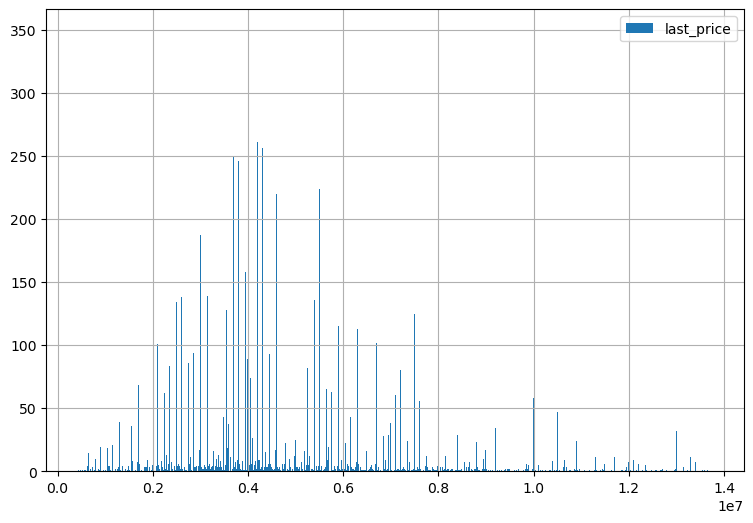

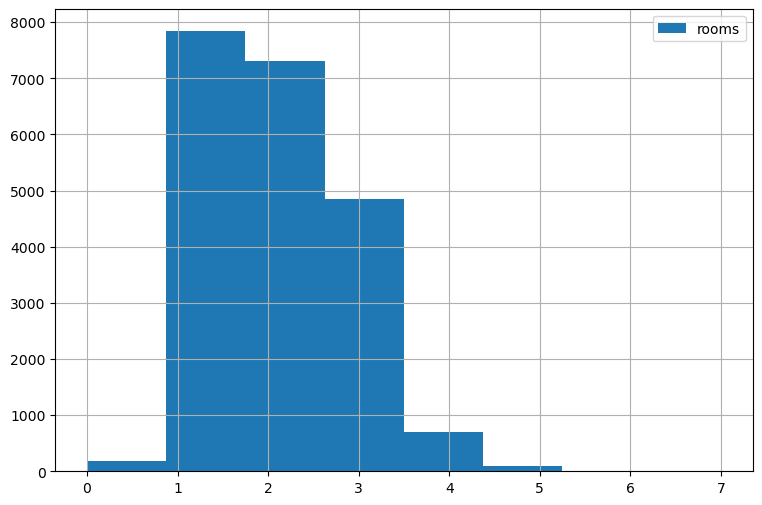

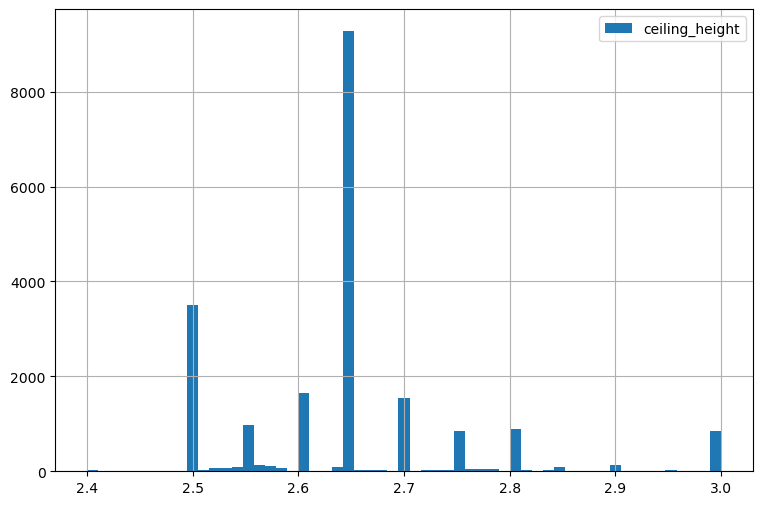

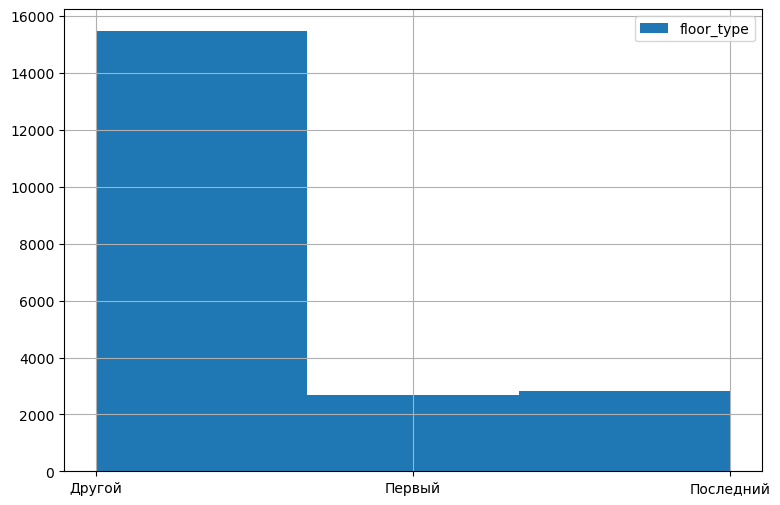

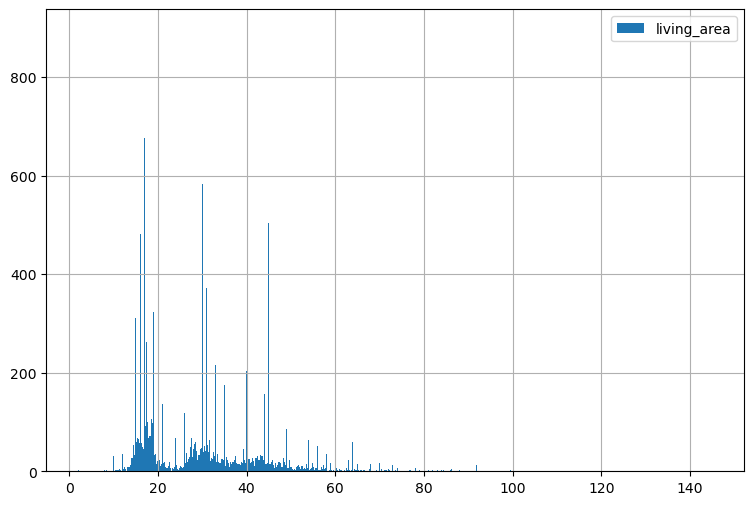

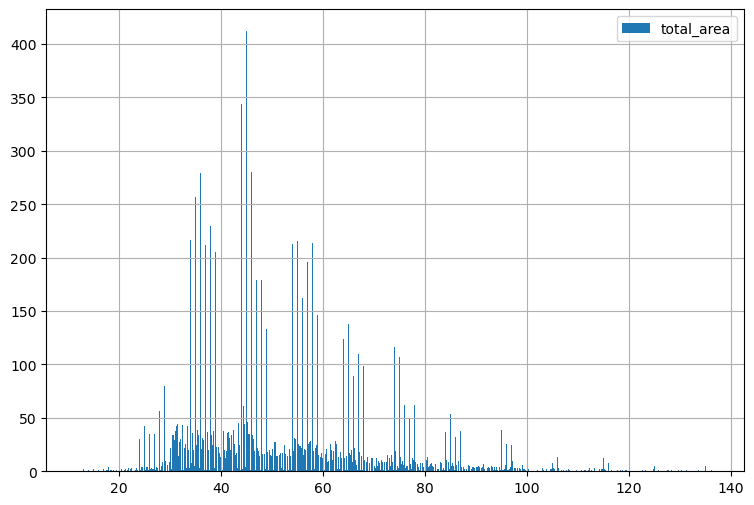

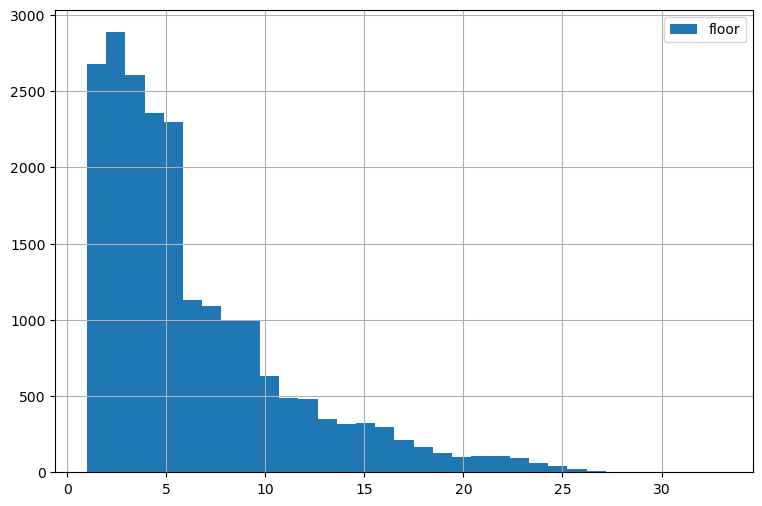

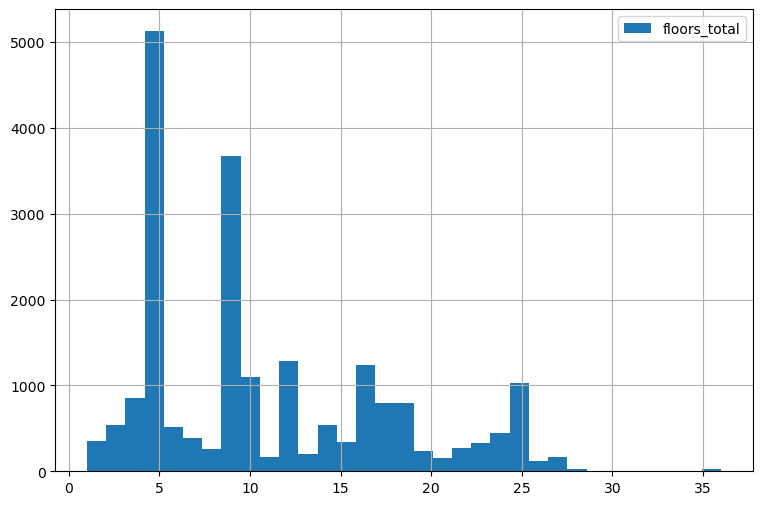

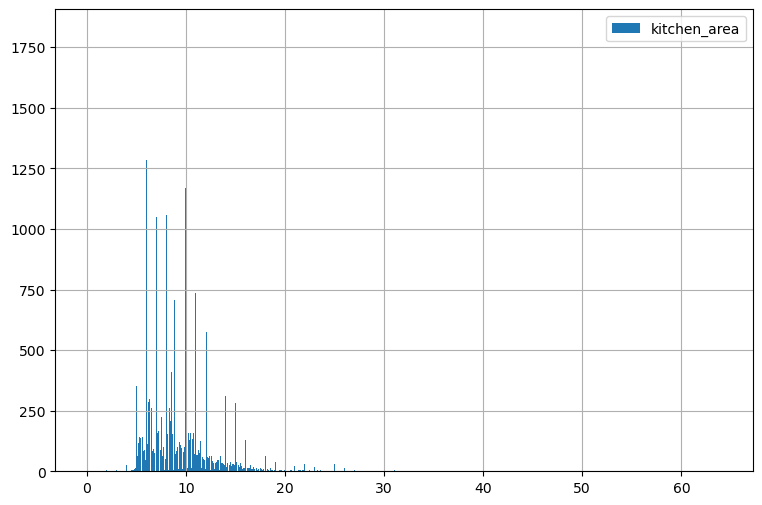

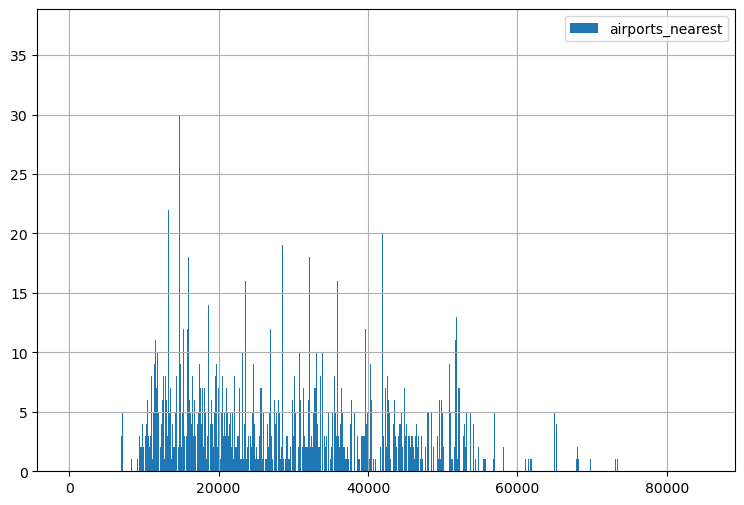

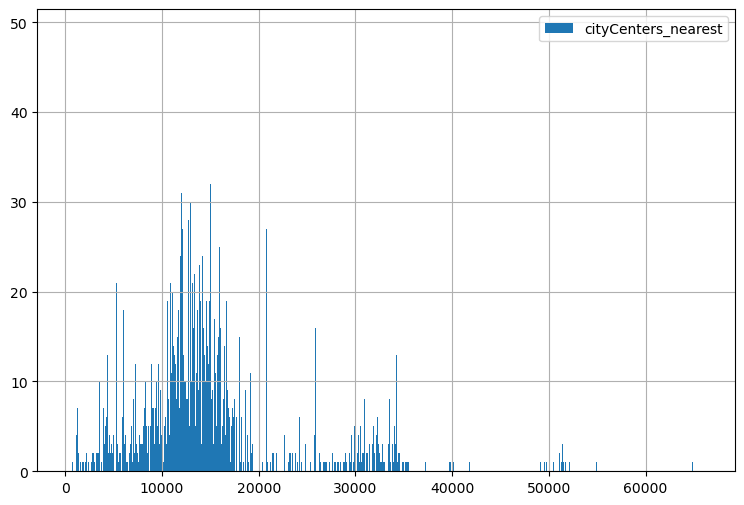

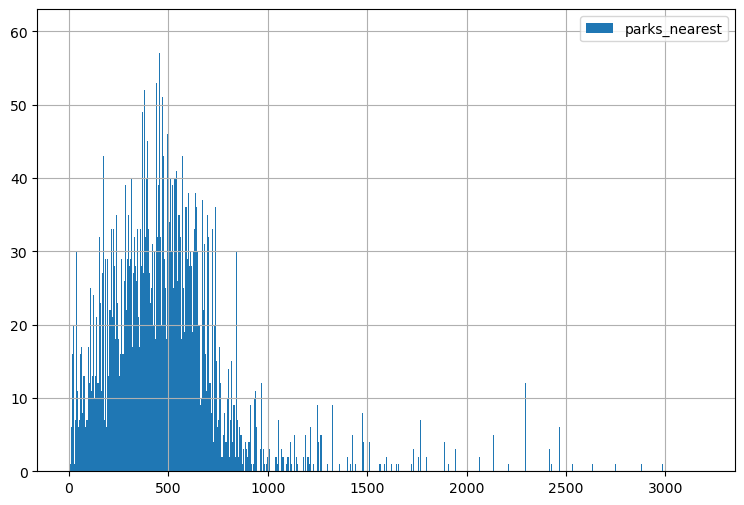

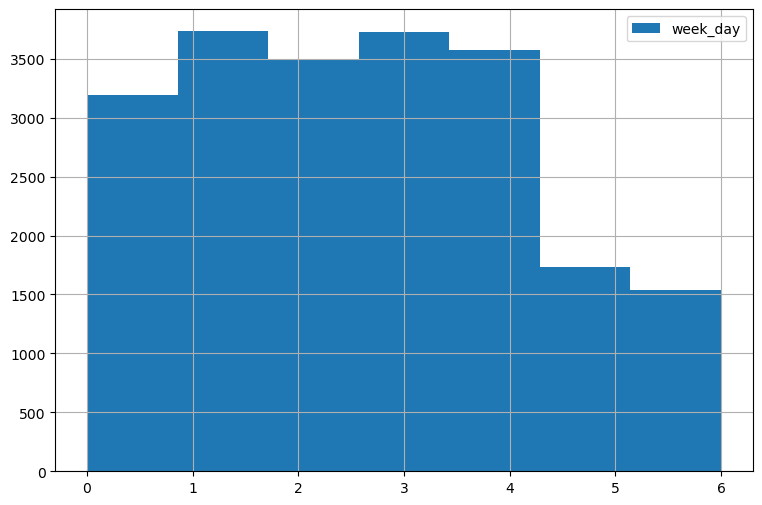

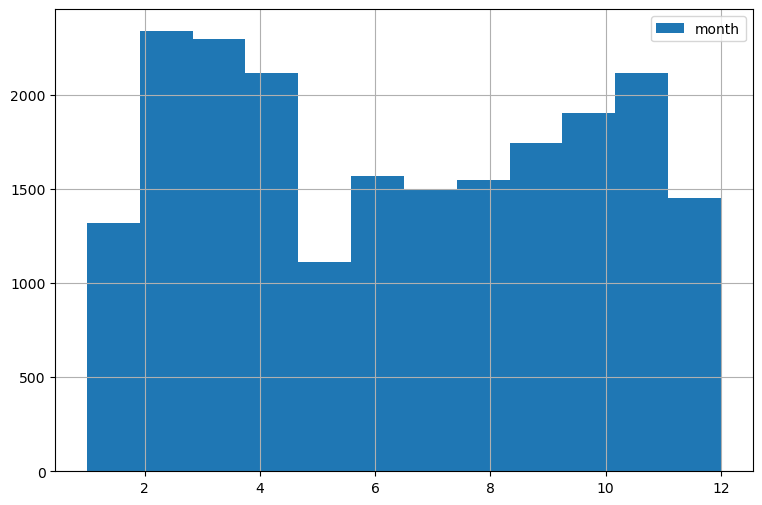

In [30]:
param_list = ['last_price', 'rooms', 'ceiling_height', 'floor_type', 'living_area','total_area', 'floor', \
'floors_total', 'kitchen_area', 'airports_nearest', 'cityCenters_nearest', 'parks_nearest', 'week_day', 'month']

for st in param_list:
    df[st].hist(figsize=(9,6), bins=df[st].nunique(), legend=True)
    plt.show()

**Из-за наличия экстремальных значений хочется поближе посмотреть на гистограммы для площади, цены**

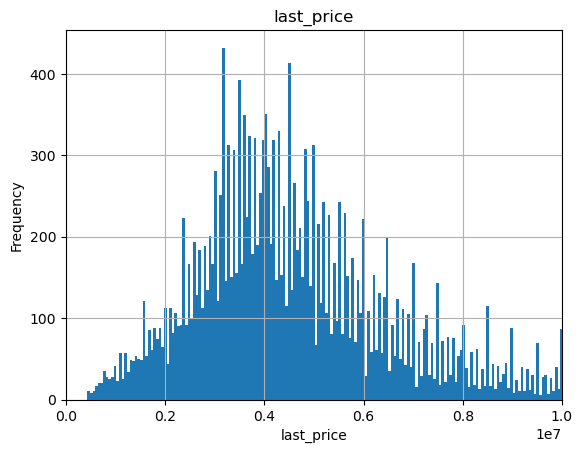

In [31]:
df['last_price'].plot(kind='hist', grid=True, title='last_price', xlim=(0,1e7), bins=250)
plt.xlabel('last_price')
plt.show()

count    2.098500e+04
mean     4.873525e+06
std      2.386452e+06
min      4.300000e+05
25%      3.300000e+06
50%      4.370000e+06
75%      5.950000e+06
max      1.375000e+07
Name: last_price, dtype: float64


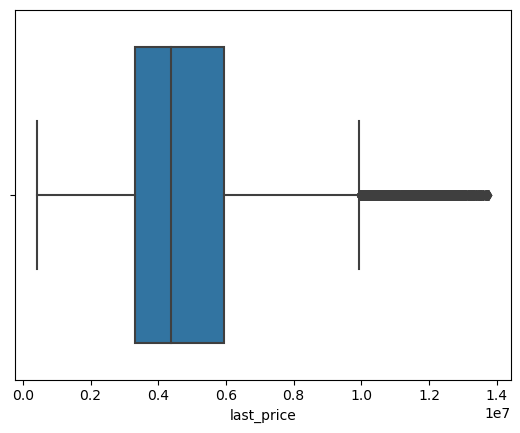

In [32]:
print(df['last_price'].describe())
sns.boxplot(x=df['last_price'])
#plt.xlim(0, 1e6)
plt.show()

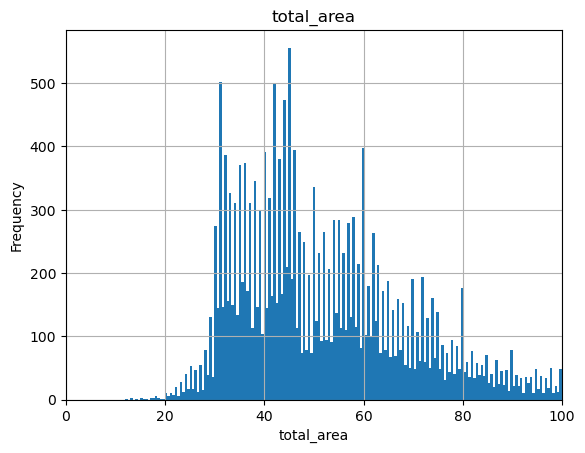

In [33]:
df['total_area'].plot(kind='hist', grid=True, title='total_area', xlim=(0,100), bins=250)
plt.xlabel('total_area')
plt.show()

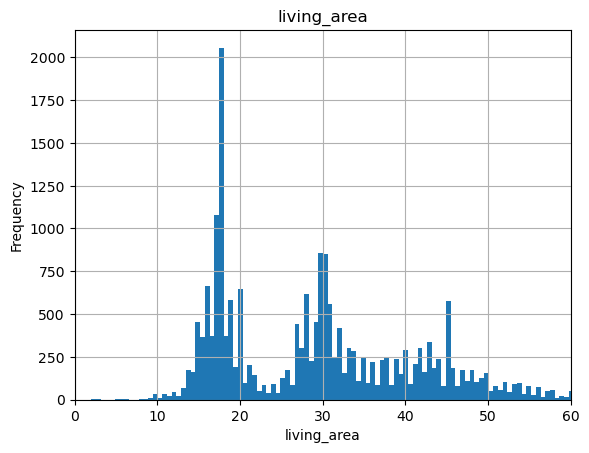

In [34]:
df['living_area'].plot(kind='hist', grid=True, title='living_area', xlim=(0,60), bins=250)
plt.xlabel('living_area')
plt.show()

### Выводы по гистограммам

<div class="alert alert-info"> 
    
**Выводы по гистограммам**
    

**1. Цена**
- Распределение похоже на нормальное с длинным хвостом в сторону больших значений, что обусловлено наличием элитной недвижимости в базе данных. В данном случае такие экстремальные значения были отброшены.
- очень дешевые объекты в базе обусловлены сильным социальным и финансовым расслоением по региону. Например, в отдаленном поселке недвижимость может быть очень дешевой. Экстремально дешевые объекты (меньше 400000р) также были отброшены.
- Наиболее частотные значения (от 2,5 до 5 млн) выглядят правдоподобно для исследуемого региона
- В столбце "аппартаменты" пропуски были либо пропуски, либо значение False. В предположении, что для жилой недвижимости (квартиры) этот критерий вообще неприменим, пропуски заполнены значением False

    
**2. Площадь (жилая, полная, кухни) и количество комнат**
    
- Длинный хвост в сторону больших значений площади также обусловлен наличием элитной недвижимости. В данном случае такие экстремальные значения были отброшены.
- на графиках (особенно, для жилой площади) видны характерные пики, обусловленные общепринятыми в сегменте массового жилья стандартными площадями для студий, 1-, 2- и 3 комнатных квартир, что также согласуется с гистограммой количества комнат

    
**3. Высота потолков**

- Видны характерные пики в области минимально допустимого значения (2,5) м, практически все остальное составляет высота, стандартная для массового сегмента - 2,65 м.

**4. Тип этажа**

- Глубокомысленный вывод, что в домах, как правило, "других" этажей больше, чем "первых" и "последних"
- казалось бы, первых и последних этажей должно быть поровну, тем не менее, меньшее количество квартир на первом этаже объясняется тем, что на первом этаже часто размещаются нежилые помещения.
    
**5. Этаж квартиры и этажность общая**
- хорошо видны общепринятые стандарты строительства: 4, 5, 9, 12 и 16 этажей.

**6. Расстояние до аэропорта и парка**
- по этим гистограммам сложно сделать какие-то выводы, потому что, как было показано ранее, для многих населенных пунктов этих данных в принципе нет. Также, например, возможна ситуация, что для Автово расстояние до Пулково указано, поскольку Автово в черте города, и картографические данные заданы корректно, а для Стрельны, находящейся на том же расстоянии от Пулково, но за городом - нет.
- расстояние до парка - видно, что факт наличия парка указывался в объявлениях в основном, если парк ближе 1000 м. На большем расстоянии лишь в малом количестве случаев этот параметр считался достойным упоминания.

**7. Расстояние до центра города**
- в основном, судя по всему, эти данные есть для Петербурга. В целом гистограмма выглядит реалистично: по мере отдаления от центра плотность жилой застройки возрастает. 
- длинный хвост с расстояниями свыше 40 км обусловлен особенностями [административно-территориального деления Санкт-Петербурга](https://ru.wikipedia.org/wiki/%D0%90%D0%B4%D0%BC%D0%B8%D0%BD%D0%B8%D1%81%D1%82%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%BE-%D1%82%D0%B5%D1%80%D1%80%D0%B8%D1%82%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%A1%D0%B0%D0%BD%D0%BA%D1%82-%D0%9F%D0%B5%D1%82%D0%B5%D1%80%D0%B1%D1%83%D1%80%D0%B3%D0%B0) и скорее всего состоит из квартир в Петродворцовом, Курортном и Кронштадтском районах

    
**8. День и месяц публикации объявления**
- объявления обычно публикуют по будням, что может говорить о существенном участии агенств.
- лето и новогодние праздники - "низкий сезон" по продажам квартир.
</div>

### Длительность продажи квартиры

count    18455.000000
mean       171.602330
std        210.454569
min          1.000000
25%         43.000000
50%         90.000000
75%        216.000000
max       1580.000000
Name: days_exposition, dtype: float64
AxesSubplot(0.125,0.11;0.775x0.77)


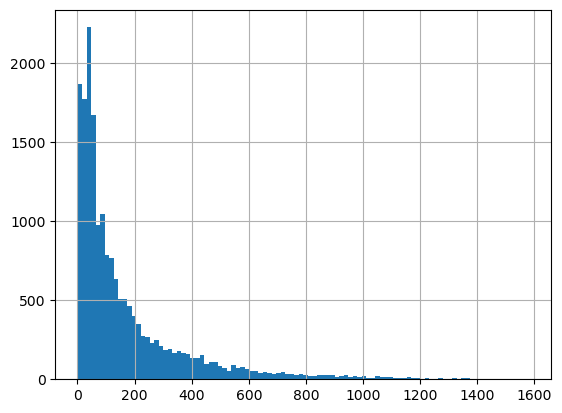

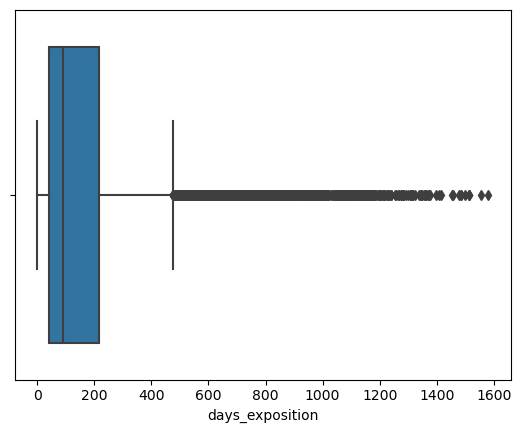

In [35]:
print(df['days_exposition'].describe())
print(df['days_exposition'].hist(bins=100))
plt.show()
#plt.ylim=(0, 800)
#df.boxplot(column='days_exposition')

sns.boxplot(x=df['days_exposition'])
#plt.xlim(0, 1000)
plt.show()

Пока сложно что-то сказать. Большинство квартир продается в течение 1-3 месяцев, однако, есть объекты, продающиеся годами. Но здесь целесообразно расссматривать длительность продажи совместно с размером населенного пункта. Условно выделим Петербург, крупные города в области, поселки и деревни/станционные поселки/садовые товарищества. Также надо посмотреть зависимость длительности продажи от цены.

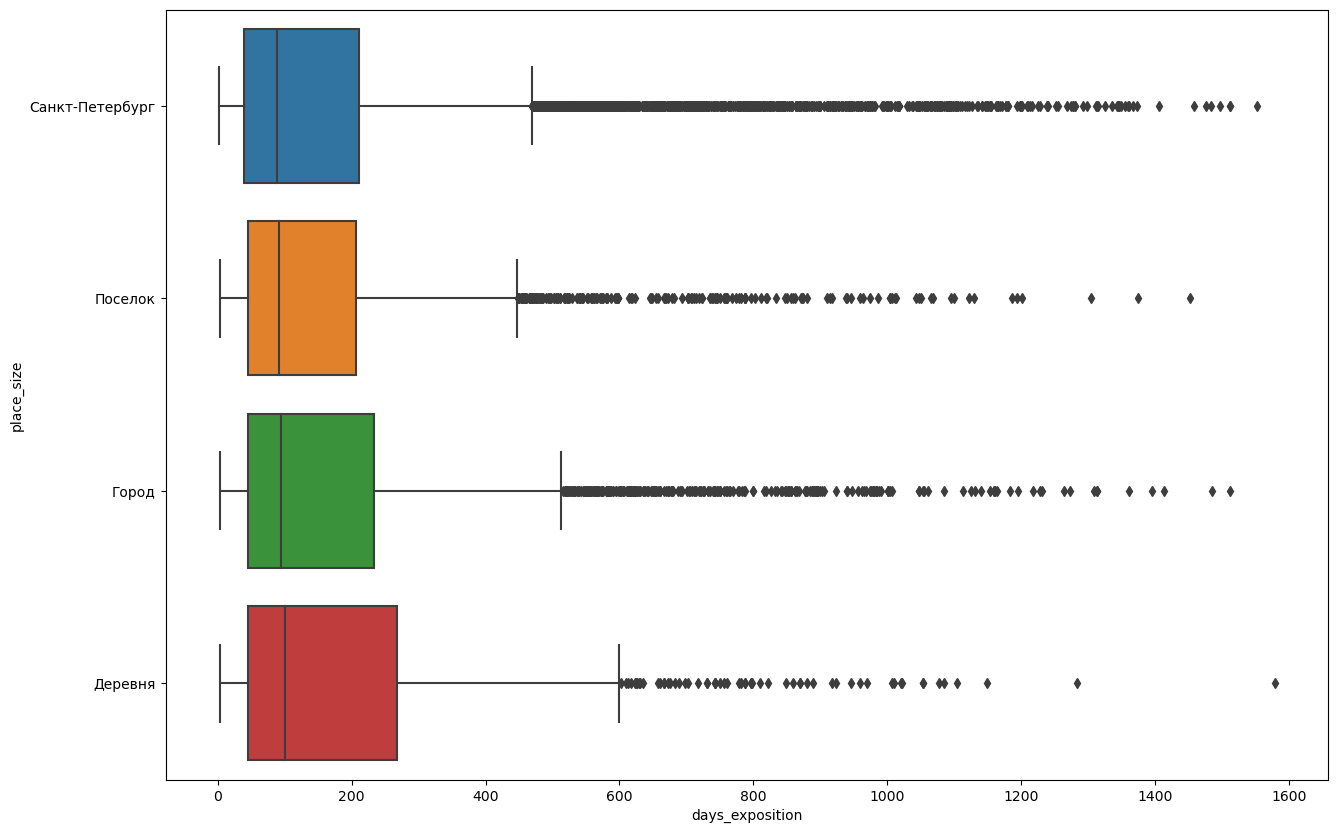

Санкт-Петербург
count    11756.000000
mean       169.491409
std        211.792116
min          1.000000
25%         39.000000
50%         89.000000
75%        211.000000
max       1553.000000
Name: days_exposition, dtype: float64
Поселок
count    2338.000000
mean      164.246364
std       193.819351
min         3.000000
25%        45.000000
50%        91.000000
75%       206.000000
max      1452.000000
Name: days_exposition, dtype: float64
Город
count    3507.000000
mean      178.309096
std       212.358142
min         3.000000
25%        45.000000
50%        95.000000
75%       233.000000
max      1512.000000
Name: days_exposition, dtype: float64
Деревня
count     854.000000
mean      193.257611
std       225.647655
min         3.000000
25%        45.000000
50%       100.000000
75%       267.750000
max      1580.000000
Name: days_exposition, dtype: float64


In [36]:
#функция для группировки населенных пунктов
def city_size(str):
    if 'Петербург' in str:
        return('Санкт-Петербург')
    elif 'поселок' in str:
        return('Поселок')
    elif 'деревня' in str or 'село' in str or 'товарищество' in str or 'кооператив' in str or 'станции' in str:
        return('Деревня')
    else:
        return('Город')

df['place_size'] = df['locality_name'].apply(city_size)


plt.figure(figsize=(15, 10))
sns.boxplot(data=df, x="days_exposition", y="place_size")
plt.show()

for st in df['place_size'].unique():
    print(st)
    print(df.loc[df['place_size'] == st]['days_exposition'].describe())

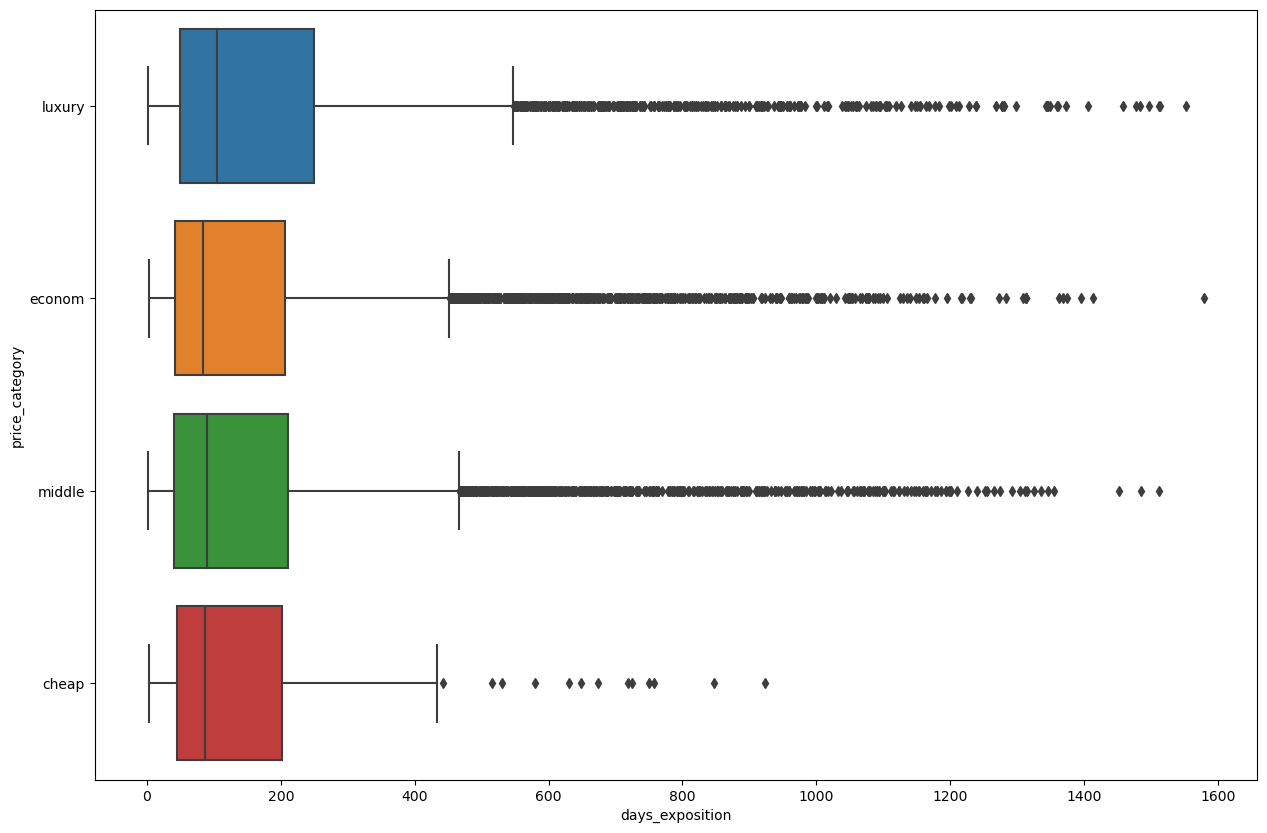

In [37]:
#группировка по цене
def price_cat(price):
    if price <= 1e6:
        return('cheap')
    elif 1e6 <= price < 4e6:
        return('econom')
    elif 4e6 <= price < 6e6:
        return('middle')
    else:
        return('luxury')

df['price_category'] = df['last_price'].apply(price_cat)
plt.figure(figsize=(15, 10))
sns.boxplot(data=df, x="days_exposition", y="price_category")
plt.show()
    

<div class="alert alert-info"> 
    
**Вывод по длительности продажи**
    
- В деревнях и малых населенных пунктах недвижимость в целом продается дольше
- Для остальных населенных пунктов разницы практически нет. За полгода продается 75% всех квартир, все, что висит дольше можно считать аномально длинной продажей
- Продажи, которые происходят менее, чем за 3 недели могут считаться "быстрыми"
- Дорогое жилье продается дольше. Но разница не столь драматична, как могло бы показаться.
- пик в районе длительности размещения около 100 дней - это длительность публикации объявления на площадке, посде чего объект либо удаляется, либо размещается заново


</div>

<AxesSubplot: >

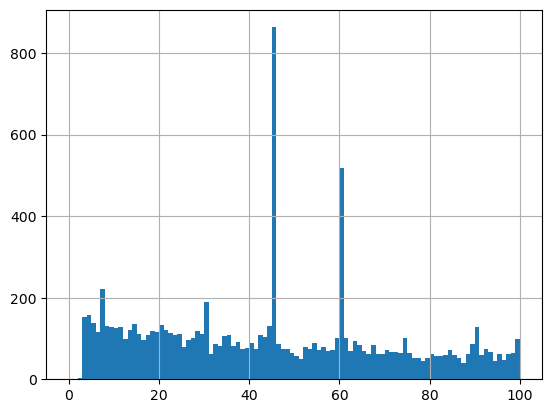

In [38]:
df['days_exposition'].hist(bins=100, range=(0,100))

### Влияние различных параметров на цену

In [39]:
#соберем новый датасет из интересующих столбцов
df_1 = pd.DataFrame({"total_area" : df['total_area'],
                      "living_area" : df['living_area'],
                      "kitchen_area" : df['kitchen_area'],
                    "rooms" : df['rooms'], 
                    "floor_type" : df['floor_type'], 
                    "week_day" : df['week_day'], 
                    "month" : df['month'], 
                    "year" : df['year'], 
                    "price" : df['last_price']})

#for col in df_1.columns:
    #c = df_1['price'].corr(df_1[col])
    #print(f'Коэффициент корреляции параметров price и {col} - {c}')
    #df_1.plot(x=col, y='price', kind='scatter', grid=True, alpha=.1)
    #plt.show()

Коэффициент корреляции цены и общей площади 0.7181605888109017


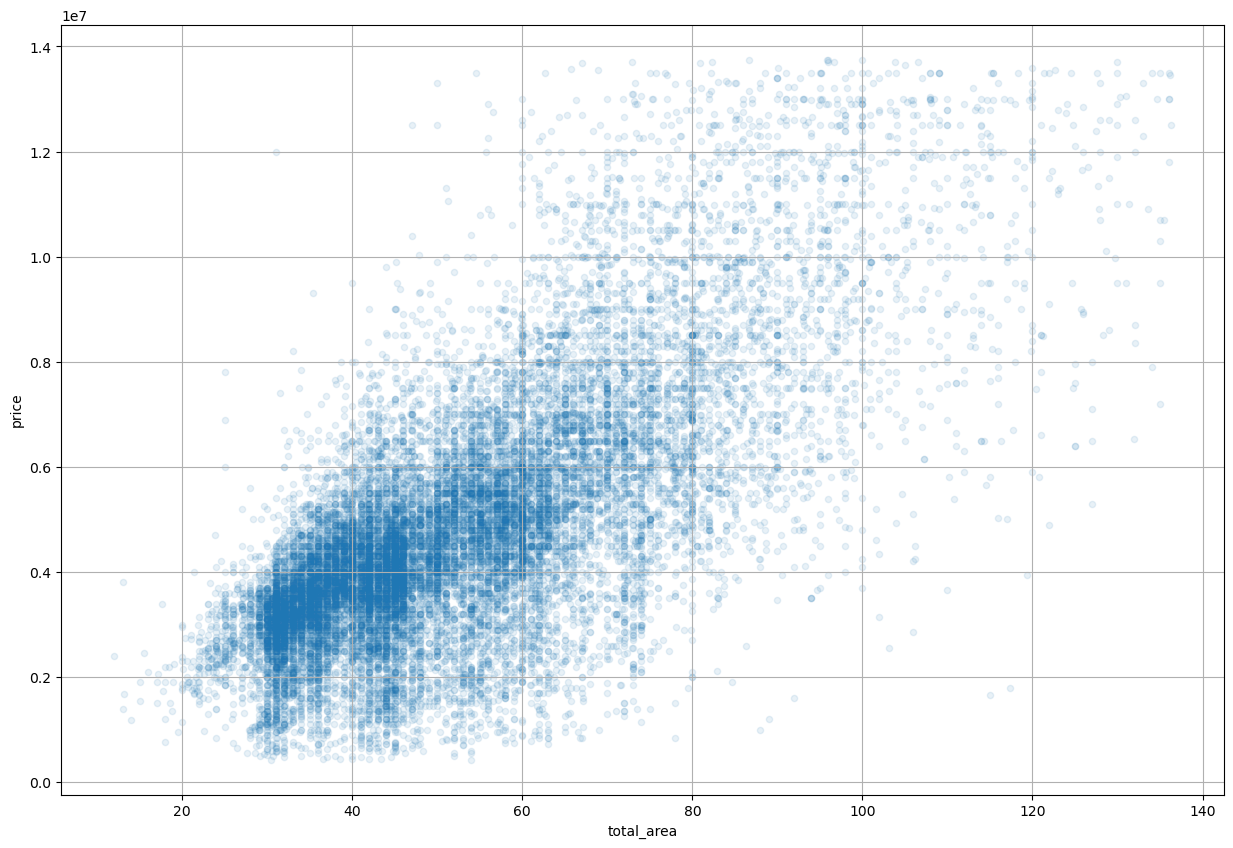

In [40]:
c = df_1['price'].corr(df_1['total_area'])
print(f'Коэффициент корреляции цены и общей площади {c}')

df_1.plot(figsize=(15, 10), x='total_area', y='price', kind='scatter', grid=True, alpha=.1)
#plt.xlim(0, 100)
#plt.ylim(0, 2e7)
plt.show()

Коэффициент корреляции цены и жилой площади 0.5669167064437729


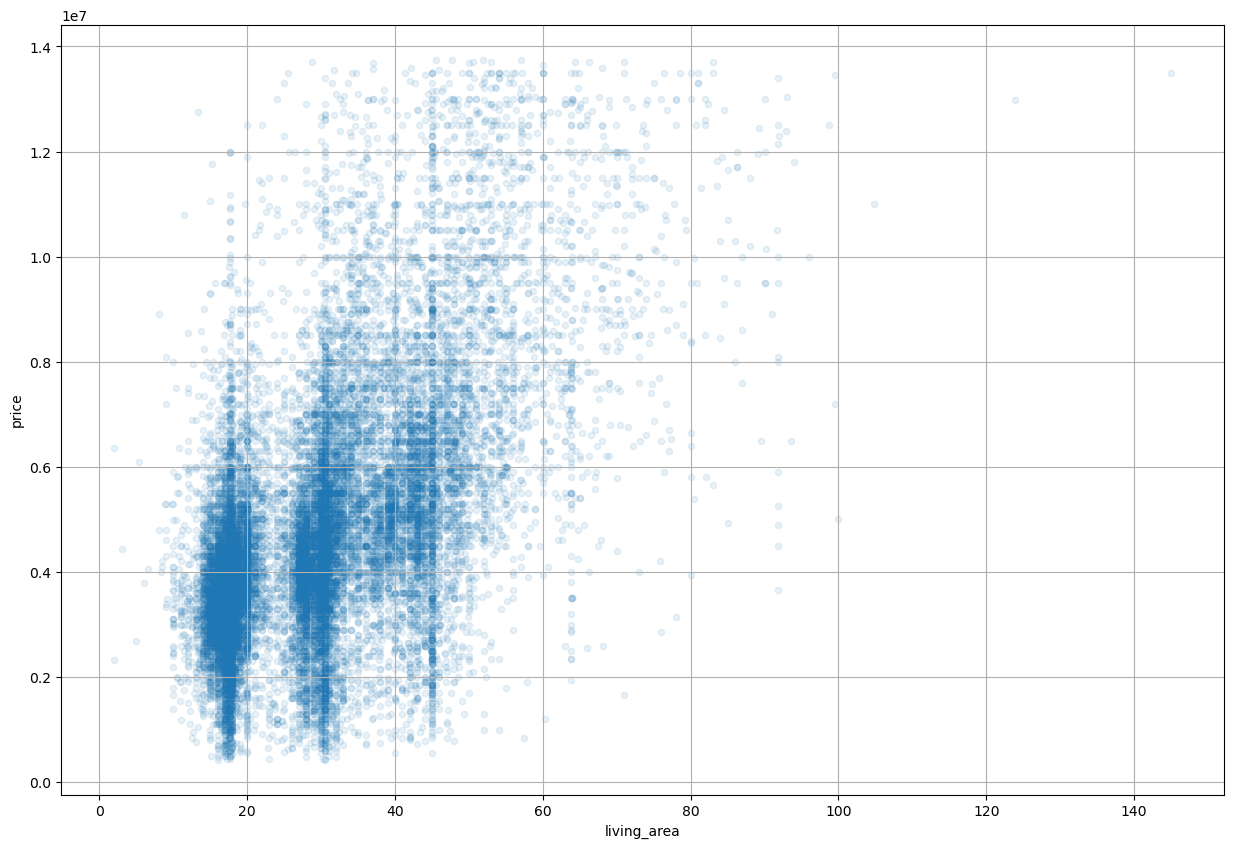

In [41]:
c = df_1['price'].corr(df_1['living_area'])
print(f'Коэффициент корреляции цены и жилой площади {c}')

df_1.plot(figsize=(15, 10), x='living_area', y='price', kind='scatter', grid=True, alpha=.1)
#plt.xlim(0, 100)
#plt.ylim(0, 2e7)
plt.show()

Коэффициент корреляции цены площади кухни 0.4951070258035895


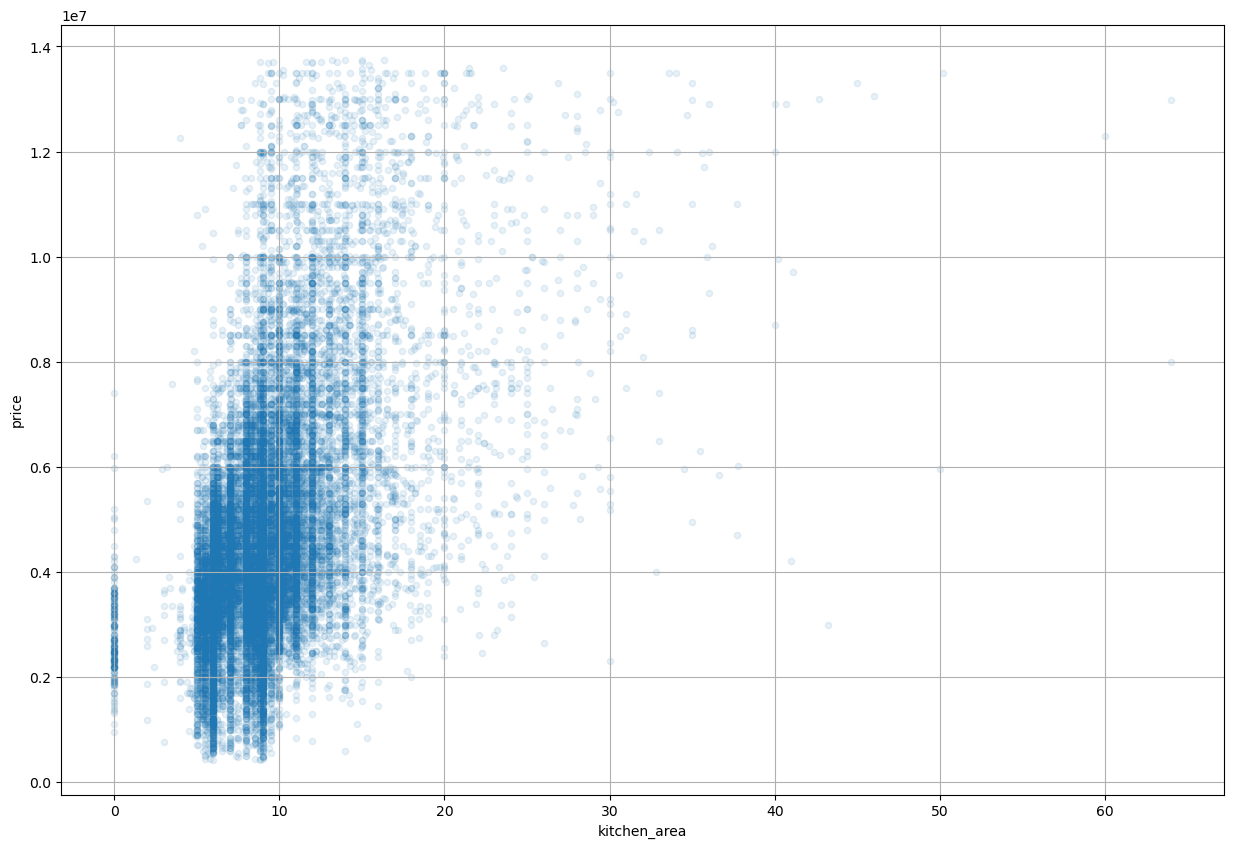

In [42]:
c = df_1['price'].corr(df_1['kitchen_area'])
print(f'Коэффициент корреляции цены площади кухни {c}')

df_1.plot(figsize=(15, 10), x='kitchen_area', y='price', kind='scatter', grid=True, alpha=.1)
#plt.xlim(0, 40)
#plt.ylim(0, 2e7)
plt.show()

Коэффициент корреляции цены и количества комнат 0.4496044808341317


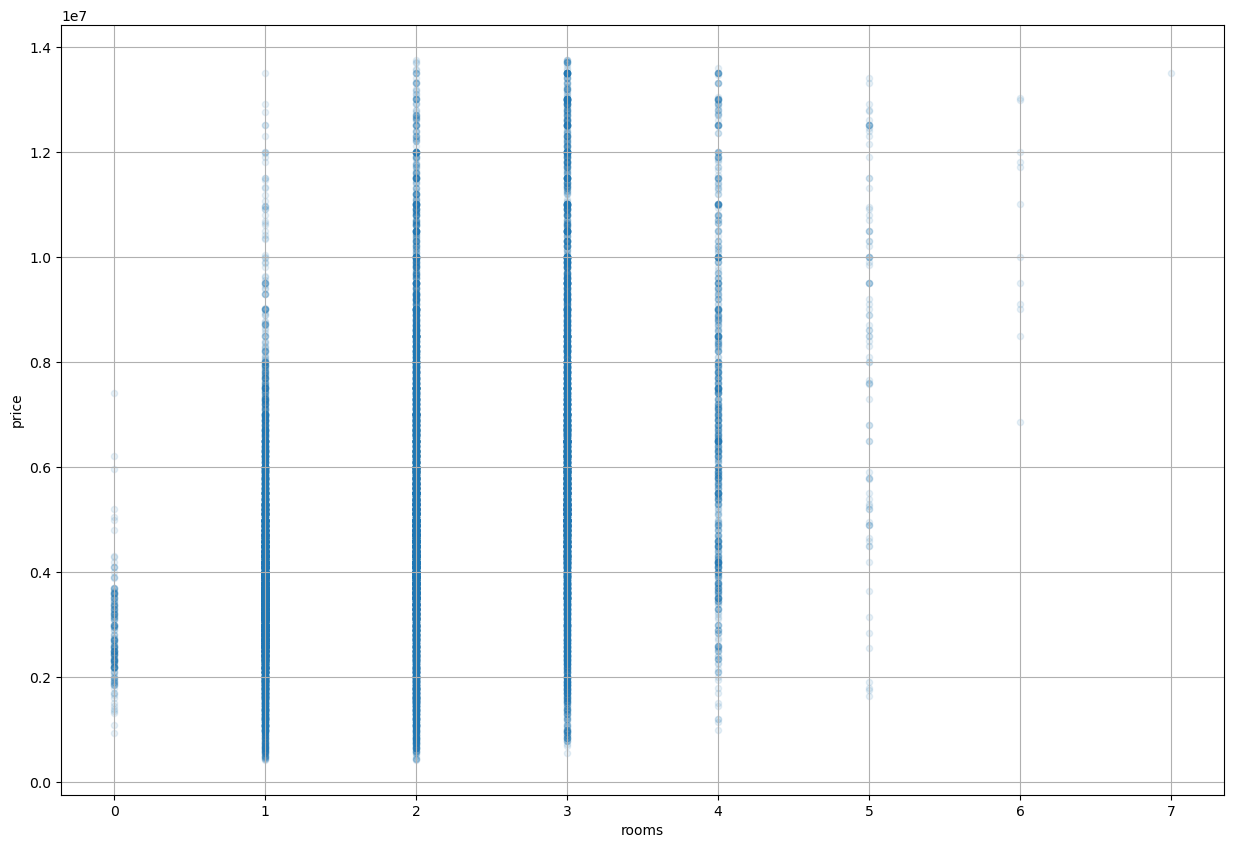

In [43]:
c = df_1['price'].corr(df_1['rooms'])
print(f'Коэффициент корреляции цены и количества комнат {c}')

df_1.plot(figsize=(15, 10), x='rooms', y='price', kind='scatter', grid=True, alpha=.1)
#plt.xlim(0, 10)
#plt.ylim(0, 2e7)
plt.show()

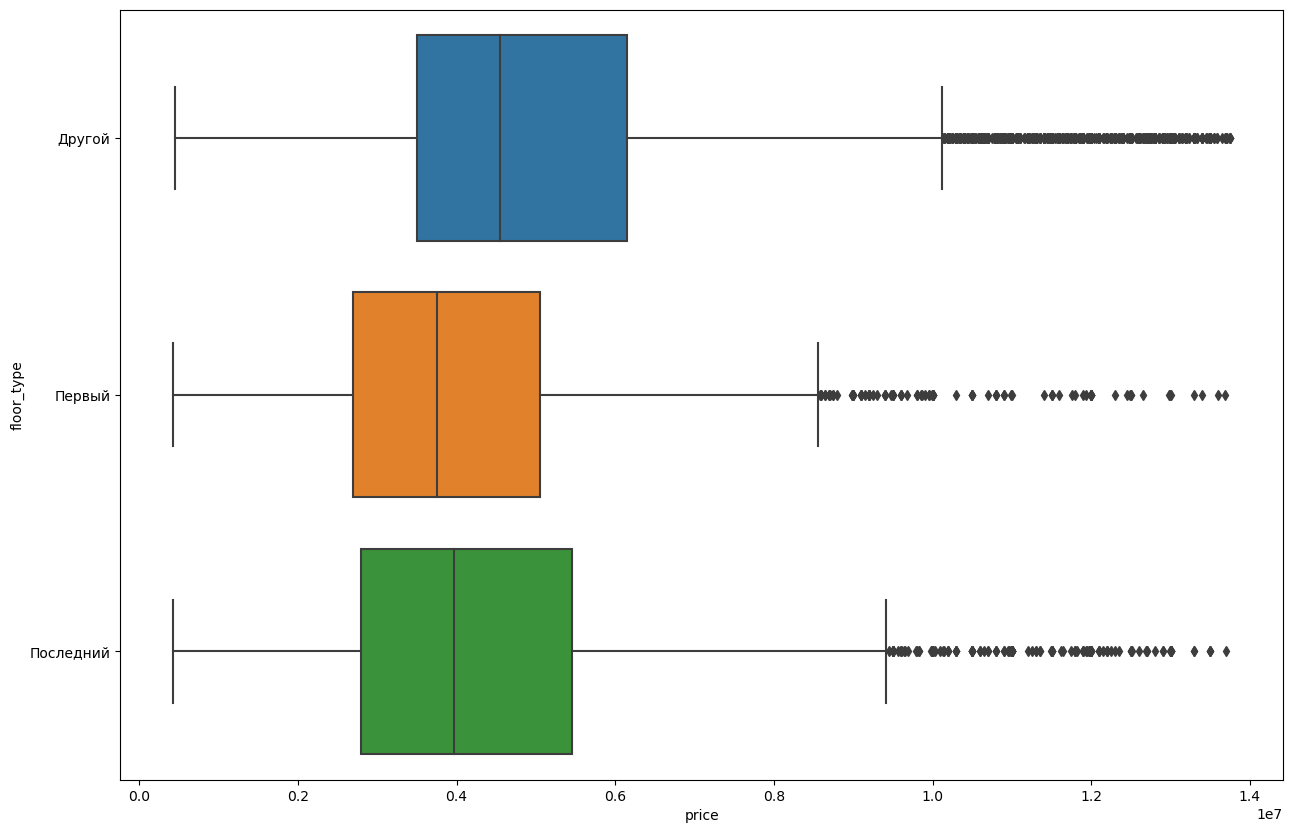

In [44]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_1, x="price", y="floor_type")
#plt.xlim(0, 2e7)
plt.show()

<AxesSubplot: xlabel='week_day'>

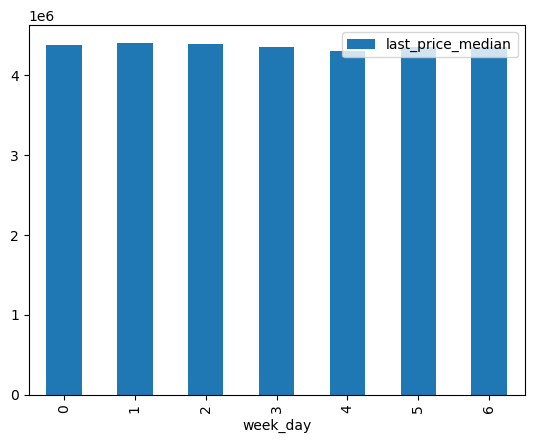

In [45]:
df_grouped_day = df.groupby('week_day').agg({'last_price':['median']})
df_grouped_day.columns = df_grouped_day.columns.map('_'.join)
df_grouped_day.plot.bar()


<AxesSubplot: xlabel='year'>

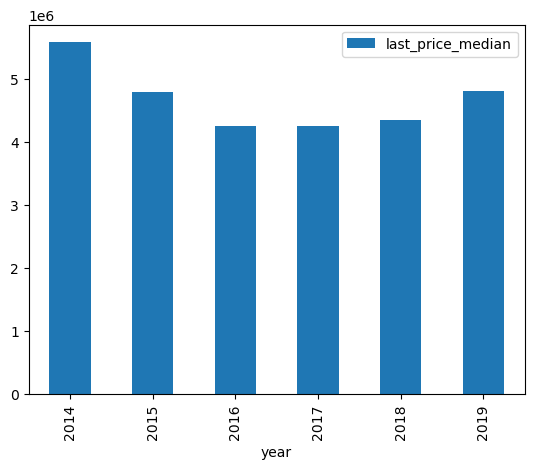

In [46]:
df_grouped_year = df.groupby('year').agg({'last_price':['median']})
df_grouped_year.columns = df_grouped_year.columns.map('_'.join)
df_grouped_year.plot.bar()

<AxesSubplot: xlabel='month'>

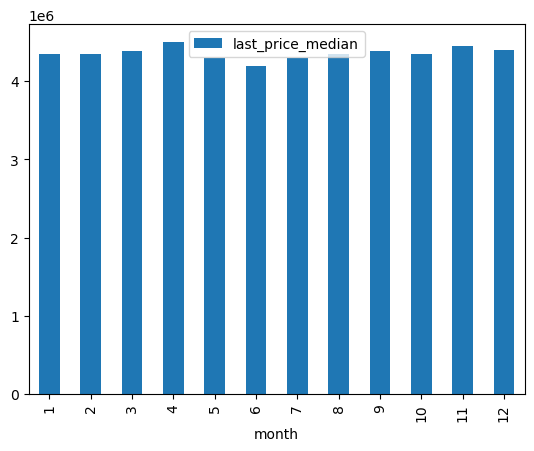

In [47]:
df_grouped_month = df.groupby('month').agg({'last_price':['median']})
df_grouped_month.columns = df_grouped_month.columns.map('_'.join)
df_grouped_month.plot.bar()

<div class="alert alert-info"> 
    
**Вывод по влиянию различных параметров на цену**
    
- Очевидна положительная корреляция между ценой и площадью.
- Значимой корреляции между ценой и количеством комнат не выявлено. Это объясняется тем, что квартиры с любым количеством комнат есть практически в любой ценовой категории
- От дня недели цена не зависит
- Есть небольшая зависимость цены квартиры от месяца продажи, видно, что летом квартиры покупают менее активно
- В 2014 году что-то случилось, вследствие чего на фоне экономического кризиса цены на недвижимость упали, а затем постепенно отрастали обратно. Жаль, что нет данных после 2019 года....

</div>

### 10 населенных пунктов с наибольшим числом объявлений

<AxesSubplot: xlabel='locality_name'>

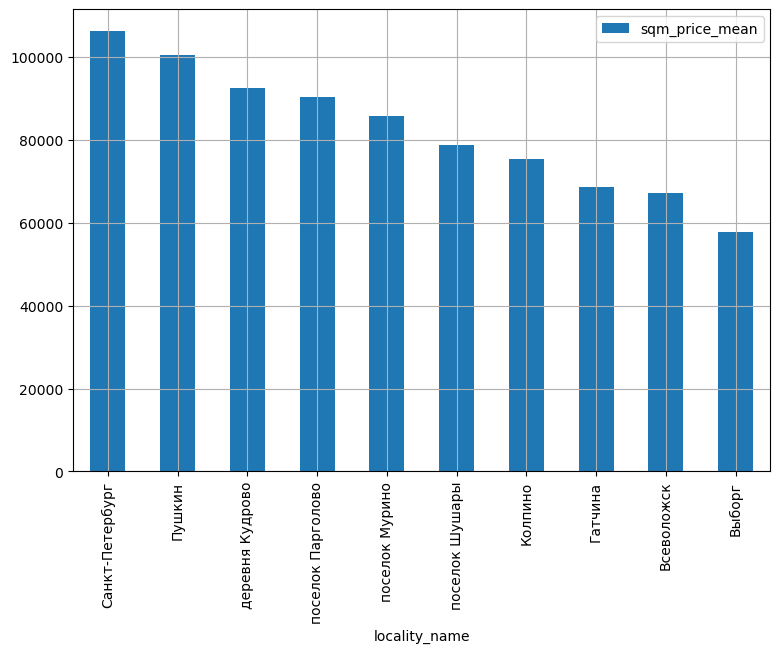

In [48]:
max_adv = df.groupby('locality_name').agg({'sqm_price':['mean', 'count']})
max_adv.columns = max_adv.columns.map('_'.join)
max_adv = max_adv.sort_values(by='sqm_price_count', ascending=False).reset_index()
max_adv_10 = max_adv.loc[:9].sort_values(by='sqm_price_mean', ascending=False)

max_adv_10.plot(x='locality_name', y='sqm_price_mean', kind='bar', grid=True, figsize=(9, 6))



<div class="alert alert-info"> 
    
**Вывод по средней стоимости квадратного метра**
    
- С Питером все понятно, 1 место
- Пушкин - предположительно - потому что наиболее приятный из ближних пригородов. 
- Деревня Кудрово - скорее всего аномалия. Там мало что от деревни осталось, вероятно, туда попали объявления, относящиеся к Кудрово-городу. Возможно, при первичной обработке данных имело смысл эти населенные пункты слить в один.
- а за Выборг и Гатчину обидно...

</div>

### Средняя цена километра в Петербурге

<AxesSubplot: xlabel='center_dist'>

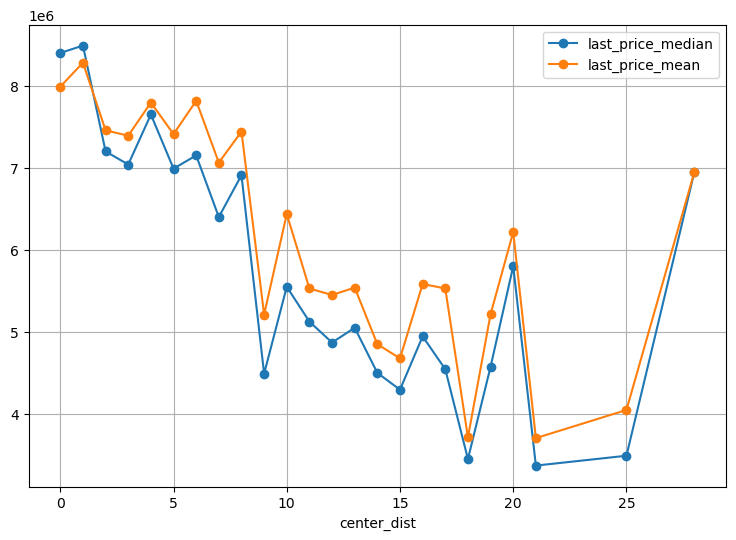

In [49]:
df_spb = df.query('locality_name == "Санкт-Петербург"').dropna()
km_price = df_spb.groupby('center_dist').agg({'last_price':['median', 'mean']})
km_price.columns = km_price.columns.map('_'.join)

km_price.plot(figsize=(9,6), grid=True, style='-o')

<div class="alert alert-info"> 
    
**Вывод по изменению стоимости по мере удаления от центра Санкт-Петербурга**
    
- По мере удаления от центра города цена падает
- После удаления очень дорогих объектов из центра города среднее приблизилось к медиане
- Всплеск цены в районе 23 км от центра либо обусловлен крайне удобным расположением, либо какой-то элитный район. Возможно, Приморский, где-то в районе Лахта-центра. Но это не точно.

</div>



<div class="alert alert-info"> 
    
## Общий вывод

**Основные результаты исследования**

**1. Предобработка**
- проанализированы причины пропусков в данных, заполнены (там, где возможно) пропущенные значения
- откорректирован тип данных
- обработаны неявные дубликаты в названиях населенных пунктов
- устранены или откорректированы аномальные значения
    
**2. Выводы по датасету**
-исследованы гистограммы для цены, площади, расположения, этажности и прочих параметров квартир
-установлены закономерности, объяснены наблюдаемые особенности в данных
    
**3. Исследование длительности продажи**
    
- В деревнях и малых населенных пунктах недвижимость продается дольше
- Для остальных населенных пунктов разницы практически нет. Очень быстрой продажжей может считаться продажа менее чем за 3 недели, очень долгой - более, чем за полгода.
- Дорогое жилье продается дольше.

**4. Исследование влияния различных параметров на цену**
    
- Очевидная положительная корреляция выявлена только между ценой и площадью.
- Летом квартиры продаются менее активно
- В 2014 году был кризис(
    
**5. Исследование средней стоимости квадратного метра**
    
- Максимальная цена квадратного метра - в Питере, Пушкине и Кудрово. Минимальная - в Выборге и Гатчине
    
**6. Исследование изменения стоимости по мере удаления от центра Санкт-Петербурга**
    
- В центре Санкт-Петербурга находится небольшое количество очень дорогих объектов. Затем средняя и медианная цена резко падают, следующий всплеск цены в районе 23 км от центра скорее всего обусловлен каким-то элитным районом. 
    
</div>